Чтение строк...
Найдено 496059 пар предложений
Отфильтровано до 28730 пар предложений
Подсчёт слов...
Количество слов:
rus 10275
eng 4307
Размер выборок: train=20111, val=4309, test=4310
['он действует от своего имени .', 'he is acting on his own behalf .']
16m 55s (- eta: 237m 3s) (5000 6%) 3.0875
33m 44s (- eta: 219m 17s) (10000 13%) 2.5799
50m 33s (- eta: 202m 14s) (15000 20%) 2.2285
67m 32s (- eta: 185m 45s) (20000 26%) 2.0052
84m 25s (- eta: 168m 51s) (25000 33%) 1.8116
161m 21s (- eta: 242m 1s) (30000 40%) 1.6814
178m 20s (- eta: 203m 49s) (35000 46%) 1.5184
195m 13s (- eta: 170m 49s) (40000 53%) 1.3661
212m 38s (- eta: 141m 45s) (45000 60%) 1.2782
229m 34s (- eta: 114m 47s) (50000 66%) 1.1850
246m 34s (- eta: 89m 39s) (55000 73%) 1.0808
263m 31s (- eta: 65m 52s) (60000 80%) 1.0226
280m 29s (- eta: 43m 9s) (65000 86%) 0.9415
297m 30s (- eta: 21m 15s) (70000 93%) 0.8379
314m 30s (- eta: 0m 0s) (75000 100%) 0.7873
> мне будет не хватать улыбки тома .
= i m going to miss tom s smile

<Figure size 640x480 with 0 Axes>

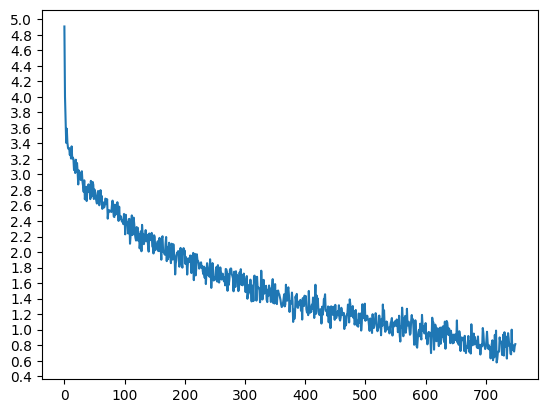

In [2]:
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import warnings
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import evaluate

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определяем два специальных токена: начало (SOS) и конец (EOS) предложения.
SOS_token = 0
EOS_token = 1

# Класс для формирования словаря языка. Он хранит отображения:
# - word2index: слово → индекс,
# - word2count: количество вхождений слова,
# - index2word: индекс → слово (для восстановления текста).
class LanguageVocabulary(object):
    def __init__(self, name):
        self.name = name  # название языка
        self.word2index = {}  # слово -> индекс
        self.word2count = {}  # слово -> число вхождений
        self.index2word = {0: "SOS", 1: "EOS"}  # индекс -> слово
        self.n_words = 2  # изначально два токена: SOS и EOS

    def add_sentence(self, sentence):
        """Добавляет предложение в словарь, разбивая его на отдельные слова."""
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            # Если слово отсутствует, добавляем его и увеличиваем счётчик слов.
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            # Если слово уже присутствует, увеличиваем его счётчик.
            self.word2count[word] += 1

# Преобразует строку Unicode в ASCII.
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Нормализует строку:
# - приводит к нижнему регистру и убирает лишние пробелы,
# - отделяет знаки препинания пробелами,
# - оставляет символы латинского и русского алфавитов (включая букву ё) и знаки . ! ?,
# - сжимает повторяющиеся пробелы.
def normalize_string(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zа-яё.!?]+", r" ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

def read_languages(lang1, lang2, reverse=False):
    print("Чтение строк...")
    # Читаем файл data/{lang1}-{lang2}.txt, где каждая строка содержит пару предложений, разделённых табуляцией.
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    # Если reverse=True, меняем местами предложения и языки.
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = LanguageVocabulary(lang2)
        output_lang = LanguageVocabulary(lang1)
    else:
        input_lang = LanguageVocabulary(lang1)
        output_lang = LanguageVocabulary(lang2)
    return input_lang, output_lang, pairs

MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    # Фильтруем пару: оба предложения должны содержать меньше MAX_LENGTH слов,
    # а перевод (второе предложение) должен начинаться с одного из указанных префиксов.
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_languages(lang1, lang2, reverse)
    print("Найдено %s пар предложений" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Отфильтровано до %s пар предложений" % len(pairs))
    print("Подсчёт слов...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Количество слов:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Разделение данных на тренировочную, валидационную и тестовую выборки.
def split_data(pairs, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    random.shuffle(pairs)
    n = len(pairs)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train_pairs = pairs[:n_train]
    val_pairs = pairs[n_train:n_train+n_val]
    test_pairs = pairs[n_train+n_val:]
    print("Размер выборок: train=%d, val=%d, test=%d" % (len(train_pairs), len(val_pairs), len(test_pairs)))
    return train_pairs, val_pairs, test_pairs

input_lang, output_lang, pairs = prepare_data('eng', 'rus', True)
# Разбиваем данные на train, val, test.
train_pairs, val_pairs, test_pairs = split_data(pairs)
print(random.choice(train_pairs))

# Энкодер – многослойная GRU.
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

# Декодер с механизмом внимания – многослойная GRU.
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, num_layers=2):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, num_layers=num_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        # Используем последний слой скрытого состояния для вычисления внимания
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[-1]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

# Преобразование предложения в последовательность индексов с использованием словаря.
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# Преобразование предложения в тензор с добавлением токена EOS.
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Преобразование пары предложений в кортеж тензоров.
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

teacher_forcing_ratio = 0.5

# Функция для обучения на одной паре (одном предложении).
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- eta: %s)' % (asMinutes(s), asMinutes(rs))

# Функция обучения, использующая только тренировочные пары.
def trainIters(encoder, decoder, train_pairs, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for epoch in range(1, n_iters + 1):
        input_tensor, target_tensor = training_pairs[epoch - 1]
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_iters),
                                         epoch, epoch / n_iters * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses)

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Функция для оценки модели на одном предложении.
def evaluate_sentences(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

bleu = evaluate.load("bleu")
references, predictions = [], []

# Функция для случайной оценки модели на заданном наборе (например, тестовой выборке).
def evaluateRandomly(encoder, decoder, eval_pairs, n=10):
    for i in range(n):
        pair = random.choice(eval_pairs)
        print('>', pair[0])
        print('=', pair[1])
        references.append(pair[1])
        output_words, attentions = evaluate_sentences(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        predictions.append(output_sentence)
        print('')
    results = bleu.compute(predictions=predictions, references=references)
    return f"BLEU Score: {results}"

# Задаём параметры модели.
hidden_size = 512
num_layers = 2

encoder1 = EncoderRNN(input_lang.n_words, hidden_size, num_layers=num_layers).to(device)
decoder1 = AttentionDecoder(hidden_size, output_lang.n_words, dropout_p=0.1, num_layers=num_layers).to(device)

# Обучение производится на тренировочной выборке.
trainIters(encoder1, decoder1, train_pairs, 75000, print_every=5000)
# Оценка проводится на тестовой выборке.
score = evaluateRandomly(encoder1, decoder1, test_pairs, n=10)
print(score)

